In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import matplotlib.image as mpimg
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score
import dlib
%matplotlib inline

In [2]:
import face_rec

Using TensorFlow backend.


# Input image

In [6]:
gref1 = cv2.imread('photo/gref_test.png')
ya = cv2.imread('photo/data.jpg')
gref2 = cv2.imread('photo/gref2.jpg')
gref3 = cv2.imread('photo/gref3.jpg')
puten = cv2.imread('photo/puten.jpg')
putin2 = cv2.imread('photo/putin2.jpg')
ya2 = cv2.imread('photo/ya.JPG')
medv = cv2.imread('photo/medv.jpg')
ebn = cv2.imread('photo/ebn.jpeg')
ebn2 = cv2.imread('photo/ebn2.jpg')
medv2 = cv2.imread('photo/medv1.jpg')

nabiu1 = cv2.imread('photo/nabiu.jpg')
nabiu2 = cv2.imread('photo/nabiu2.jpg')

ebn_bill = cv2.imread('photo/ebn_bill.jpg')
clinton = cv2.imread('photo/clinton.jpg')

clinton_face = cv2.imread('photo/clinton_face.jpeg')

# Photo recognition system

In [5]:
from PIL import Image, ImageDraw ,ImageFont , ImageColor
fnt = ImageFont.truetype('Pillow/Tests/fonts/DejaVuSans.ttf', 10)



clinton_encoded = face_rec.face_embedding(clinton_face)[0]

ebn_encoded = face_rec.face_embedding(ebn)

# Делаем array с известными фотками и пишем имена
known_face_encodings = [ebn_encoded,clinton_encoded]
known_face_names = ['Boris','Hillary']

# Загружаем общую пикчу, где нужно детектить
unknown_image = ebn2

#  Ищем все лица в пикче и энкодим
face_encodings = face_rec.face_embedding(unknown_image)
faces_loc = face_rec.face_locations(unknown_image)


#Конвертим пикчку в pil формат, чтобы поверх рисовать боксы
pil_image = Image.fromarray(unknown_image)

draw = ImageDraw.Draw(pil_image)

#чекаем на совпадение с известным лицом
for (top, right, bottom, left), face_encoding in zip(faces_loc, face_encodings):
    # чекаем на совпадение с известным лицом
    matches = face_rec.compare_faces(known_face_encodings, face_encoding)
    print(matches)
    
    name = "Unknown"
    if True in matches:
        first_match_index = matches.index(True)
        name = known_face_names[first_match_index]
        print(name)


    draw.rectangle(((left,top), (right, bottom)), outline=(0,0,255))
    # пишем лэйбл
    text_width, text_height = draw.textsize(name)
    draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
    draw.text((left + 6, bottom - text_height - 5), name,font=fnt,fill=(255, 255, 255, 255))

pil_image.show()

[True, False]
Boris


In [6]:
face_rec.distance(face_encodings,ebn_encoded)

34.581703

# Accuracy

In [7]:
from keras.models import model_from_json

json_decoder = ''
json_encoder = ''

with open('face_rec-master/models/encoder_json_32e.txt', 'r') as file:
    json_encoder = file.readline()

with open('face_rec-master/models/decoder_json_32e.txt', 'r') as file:
    json_decoder = file.readline()

D = model_from_json(json_decoder)
D.load_weights('face_rec-master/models/decoder_weights_32e.h5')

E = model_from_json(json_encoder)
E.load_weights('face_rec-master/models/encoder_weights_32e.h5')

In [9]:
%%time 
embedded = []
metadata = []
for img in glob.glob('./images/*/*.jpg'):
    
    n = cv2.imread(img)
    face = face_recognition.face_encodings(n)
    if face is not None:
            metadata.append(img.split('/')[2])
            embedded.append(face[0])

embedded = np.array(embedded)
metadata = np.array(metadata)

CPU times: user 15.1 s, sys: 3.46 ms, total: 15.1 s
Wall time: 15.1 s


In [5]:
%%time 
embedded = []
metadata = []
for img in glob.glob('./images/*/*.jpg'):
    
    n = cv2.imread(img)
    try:
        face = prp.face_embedding(n)
        metadata.append(img.split('/')[2])
        embedded.append(face)
    except Exception:
        pass
embedded = np.array(embedded)
metadata = np.array(metadata)

CPU times: user 73.7 ms, sys: 7.87 ms, total: 81.6 ms
Wall time: 80.2 ms


In [16]:
face_rec.distance(embedded[0],embedded[1])

0.0917402536566666

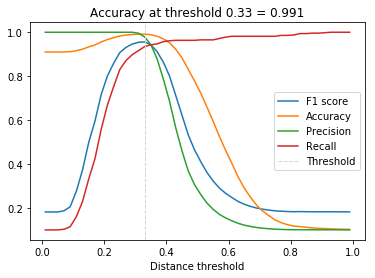

In [17]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] 
identical = [] 

num = len(metadata)
for i in range(num - 1):
    for j in range(1, num):
        #print(i,j)
        distances.append(face_rec.distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i] == metadata[j] else 0)

        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.01, 1, 0.02)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

precision = [precision_score(identical, distances < t) for t in thresholds] 
recall = [recall_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)

opt_tau = thresholds[opt_idx]

opt_acc = accuracy_score(identical, distances < opt_tau)

plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.plot(thresholds, precision, label='Precision');
plt.plot(thresholds, recall, label='Recall');

plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();